# **Grover's Search Algorithm** 

### Contributors
Davide Moretti, Filippo Tramonto, Ennio Picarelli

## Application of the Grover's search algorithm 

Below is an example of an application with Qiskit of the Grover algorithm in the case of a search in a list of 4 items using 2 qubits.

__Tutorial outline:__

1) Basic Grover's algorithm implementation to 2 qubit system - understanding the theory

2) Generalization of Grover's algorithm - defining an universal oracle
   + Exercise

3) Comparison of IBM Quantum devices - back to the 2 qubit problem

4) Running on real hardware


In [1]:
import qiskit.version

qiskit.version.get_version_info()

'1.2.4'


## 1) Basic Grover's algorithm implementation <a id='sectionB'></a>

Let's load the necessary Qiskit libraries into the Python environment and initialize the circuit


In [ ]:
%pip install --upgrade pip
%pip install -U qiskit
%pip install -U qiskit_aer
%pip install -U qiskit_ibm_runtime
%pip install -U latex
%pip install -U pandas
%pip install -U matplotlib
%pip install -U pylatexenc

import latex
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile

import numpy as np

## Let's initialize the circuit<a id='sectionB'></a>

In [9]:
# 2 bit registry creation.
qr = QuantumRegister(2, 'qr')

# Circuit creation 
qc = QuantumCircuit(qr)

# Let's build the superposition of all basis states

#### Let's build the Hadamard transform by applying the hadamard gates to the two qubits

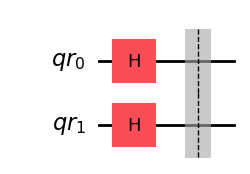

In [11]:
# Circuit creation of the Hadamard Transform
had_tr = QuantumCircuit(qr)

had_tr.h(qr[0])
had_tr.h(qr[1])
had_tr.barrier()


qc = had_tr
qc.draw(output='mpl')


We visualize the array of amplitudes after the superposition


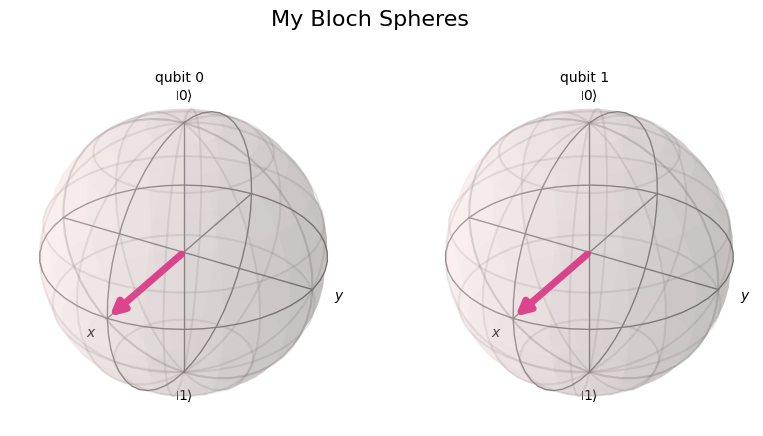

In [12]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

state = Statevector(qc)
plot_bloch_multivector(state, title='My Bloch Spheres')


## Lest's write a routine that asks the user for input to define the "card" he wants find.

In [13]:
print("\n\n\n\n===== Welcome! =====\n\n")
print("  ~~ Let's take this test ~~ ")
print("\n\n")
print("Select the winner among:")
print("a) Hearts")
print("b) Pictures")
print("c) Flowers")
print("d) Spades")
chosen = 0
while (chosen==0):
#	scelta = getpass.getpass("make your choise. (a, b, c, d, e or f)\n")
    scelta = input("Choose your card (a, b, c, d)\n")
    if scelta == "a":
        bit = "|00>"
        print("Choice: a) Hearts")
    if scelta == "b":
        bit = "|01>"
        print("Choice: b) Diamonds")
    if scelta == "c":
        bit = "|10>"
        print("Choice: c) Clubs")
    if scelta == "d":
        bit = "|11>"
        print("Choice: d) Spades")
    if scelta in ["a","b","c","d"]:
        chosen = 1
        
        print ("Linked to:", bit)
    else:
        print("wrong selection, retry")





===== Welcome! =====


  ~~ Let's take this test ~~ 



Select the winner among:
a) Hearts
b) Pictures
c) Flowers
d) Spades
Choice: b) Diamonds
Linked to: |01>


# Let's build the oracle operator

### How implement the Oracle operator in a two qubit circuit?

We have 4 basis states, $|00 \rangle$, $|01 \rangle$, $|10 \rangle$, $|11 \rangle$, and we want to mark one of them by changing the sign.

#### Let's see how can change the sign of the state of 1 qubit.

For $|1 \rangle$ we can do it by applying $H$ and $X$ as follows:
$$ |1 \rangle \xrightarrow{H} \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle) \xrightarrow{X} - \frac{1}{\sqrt{2}} ( |0\rangle - |1 \rangle)  \xrightarrow{H} - |1 \rangle $$

For $|0 \rangle$ we just add the $X$ operator before and after:
$$ |0\rangle \xrightarrow{X} |1 \rangle \xrightarrow{H} \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle) \xrightarrow{X} - \frac{1}{\sqrt{2}} ( |0\rangle - |1 \rangle)  \xrightarrow{H} - |1 \rangle \xrightarrow{X} -|0\rangle $$

#### For two qubits...

Let's make the previous qubit as the second qubit and substitute the central  $X$  with a  $\mathrm{CNOT}$  controlled by the first qubit in the state $|1 \rangle$ :
$$ |1 \rangle |1 \rangle \xrightarrow{H} |1 \rangle \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle) \xrightarrow{CNOT} - |1 \rangle \frac{1}{\sqrt{2}} ( |0\rangle - |1 \rangle)  \xrightarrow{H} - |1 \rangle |1 \rangle $$

If the first qubit is in the state $|0 \rangle$, just put a $X$ on it before the $\mathrm{CNOT}$ and another $X$ after the $\mathrm{CNOT}$ to reverse the state.

Let's draw the circuit of the oracle for the state $|11 \rangle$.

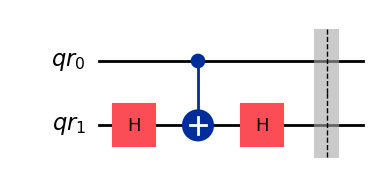

In [14]:
orac = QuantumCircuit(qr)

orac.h(qr[1])
orac.cx(qr[0],qr[1])
orac.h(qr[1])
orac.barrier()

orac.draw(output='mpl')

Let's put together with the Hadamard transform.

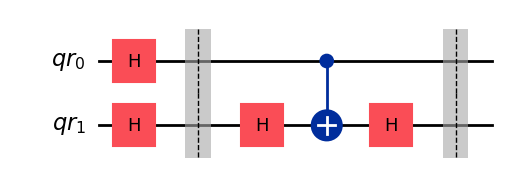

In [15]:
# The Qiskit circuit object supports concatenating circuits with the addition operator.

qc = had_tr.compose(orac)

qc.draw(output='mpl')

## We create an oracle for each searched card
In a list of if we create the Oracle function depending on the state we want find.

Let's intialize the circuit with the Hadamard transform

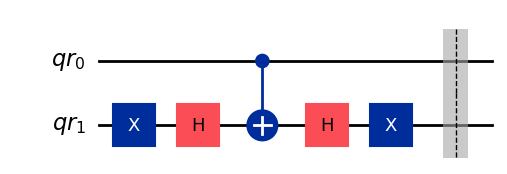

In [16]:
orac = QuantumCircuit(qr)

if scelta == "a": # |00>
    orac.x(qr[0])
    orac.x(qr[1])
    orac.h(qr[1])
    orac.cx(qr[0],qr[1])
    orac.h(qr[1])
    orac.x(qr[0])
    orac.x(qr[1])
    orac.barrier()
    bits = '00'

if scelta == "b": # |01>
    orac.x(qr[1])
    orac.h(qr[1])
    orac.cx(qr[0],qr[1])
    orac.h(qr[1])
    orac.x(qr[1])
    orac.barrier()
    bits = '01'

if scelta == "c": # |10>
    orac.x(qr[0])
    orac.h(qr[1])
    orac.cx(qr[0],qr[1])
    orac.h(qr[1])
    orac.x(qr[0])
    orac.barrier()
    bits = '10'

if scelta == "d":  # |11>
    orac.h(qr[1])
    orac.cx(qr[0],qr[1])
    orac.h(qr[1])
    orac.barrier()
    bits = '11'


orac.draw(output='mpl')

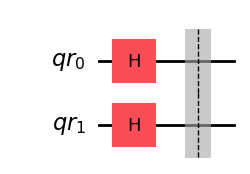

In [17]:
qc = had_tr

qc.draw(output='mpl')

Let's see the array of amplitudes, before applying the oracle operator

In [18]:
state = Statevector(qc)
state

Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
            dims=(2, 2))


Now let's apply the oracle and see the array of amplitudes after the oracle

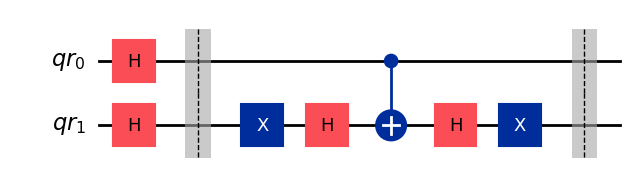

In [19]:
qc = had_tr.compose(orac)
qc.draw(output='mpl')

In [20]:
state = Statevector(qc)
state

Statevector([ 0.5+0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j],
            dims=(2, 2))


Neglecting the null imaginary component we can conclude that after the Oracle only the chosen "card" has reversed sign

## Let's create the operator $2 | 0 \rangle \langle 0 | -I $  (conditioned phase shift)

We have to build an operator $U$ that let's unchanged  the state $| 00 \rangle$ and change the sign of the other basis states, but if we build the opposite operator $V=-U$ this change only the global phase that doesn't affect the result of the measurement.

So let's build the opposite operator that changes the sign of $| 00 \rangle$ and let unchanged the other state. We have already seen this operator...

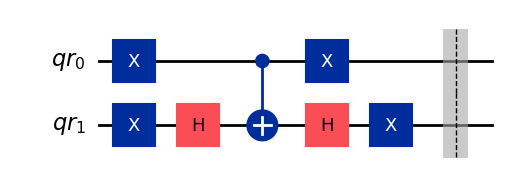

In [21]:
cphase = QuantumCircuit(qr)

cphase.x(qr[0])
cphase.x(qr[1])

cphase.h(qr[1])
cphase.cx(qr[0],qr[1])
cphase.h(qr[1])

cphase.x(qr[0])
cphase.x(qr[1])
cphase.barrier()

qc = cphase

qc.draw(output='mpl')

#### Let's put all togheter

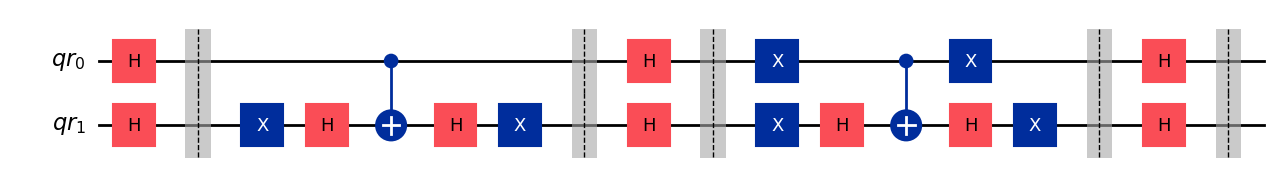

In [22]:
qc = had_tr
qc = qc.compose(orac)
qc = qc.compose(had_tr)
qc = qc.compose(cphase)
qc = qc.compose(had_tr)



qc.draw(output='mpl')

#### Let's complete the circuit with the measurements

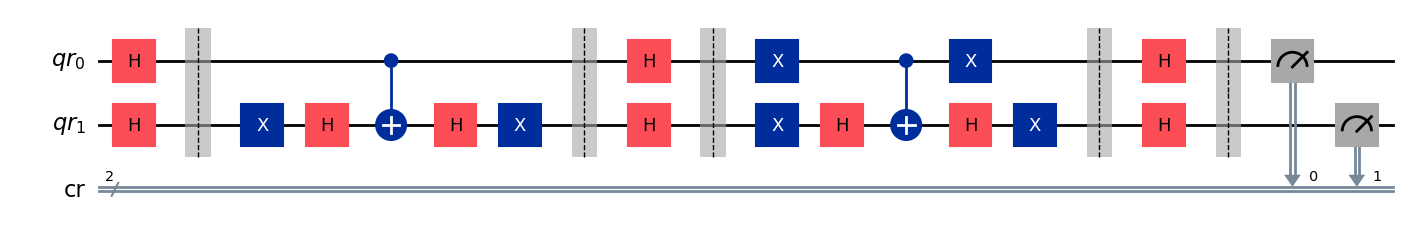

In [23]:
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(2, 'cr')

# Create a Quantum Circuit
meas = QuantumCircuit(qr, cr)

# add measurement operators
meas.measure(qr,cr)

qc = qc.compose(meas)

#drawing the circuit
qc.draw(output='mpl')

## We run the circuit in the first instance with the simulator
We report the values found in measure 

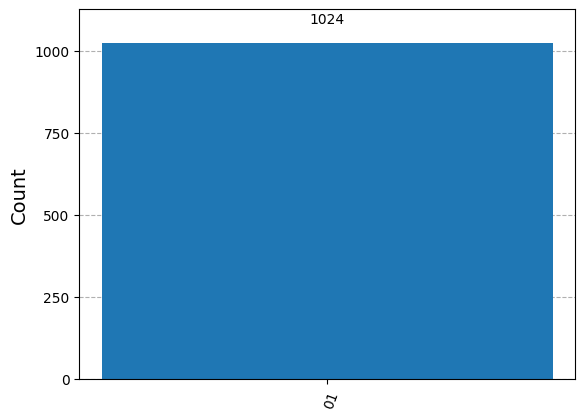

In [25]:
# Initialize the sampler using the AerSimulator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

aer_sim = AerSimulator()  
sampler = Sampler(mode=aer_sim)
transpiled_qc = transpile(qc, aer_sim, optimization_level=1)
shots = 1024

sim_result = sampler.run([transpiled_qc], shots=shots).result() #run of the transpiled circuit
dist = sim_result[0].data.cr.get_counts()

plot_histogram(dist)

That's exactly the result we expected! But we used a simulator, running on a real hardware is a little bit different, we'll face this problem on another section. Now let's focus on the algorithm a little more.

Let's see the least busy real Quantum hardware.

API Token can be found in the homepage of IBM Quantum Platform after login: https://quantum.ibm.com/

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue

token=''         #input your API key, you can find it in the IBM Quantum platform homepage
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

To understand what results we can expect to have from a real hardware let's use the *fake_provider* class, that simulates noise levels and coupling maps of the backend we would like to later run on.

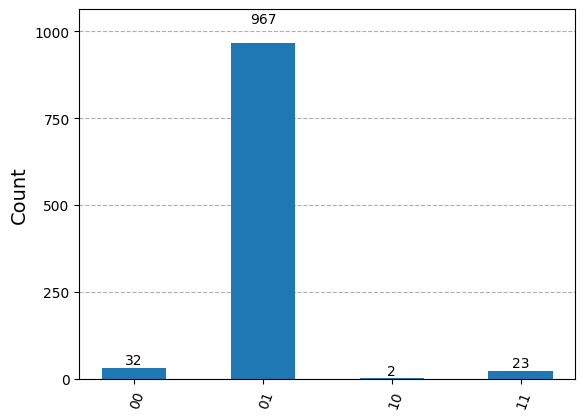

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeKyiv, FakeSherbrooke, FakeTorino

fake_backend = FakeBrisbane()   #you can change this with other Fake backends like Sheerbrooke or Kyiv
sampler = Sampler(mode=fake_backend)
transpiled_qc = transpile(qc, backend, optimization_level=1)
shots = 1024

sim_result = sampler.run([transpiled_qc], shots=shots).result() #run of the transpiled circuit
dist = sim_result[0].data.cr.get_counts()

plot_histogram(dist)

That's a more realistic result.
Now let's see how to improve the algorithm!

## 2) Generalization of the oracle and use of GroverOperator built-in Qiskit function

Tutorial link: https://learning.quantum.ibm.com/tutorial/grovers-algorithm

Let's define a generalized grove operator that takes as input only the states you want to find.

Grover's algorithm requires an oracle that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1. A controlled-Z gate, or its multi-controlled generalization over N qubits, marks the 2^N −1 state ('1' N bit-string). Marking basis states with one or more '0' in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit. In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation. The MCMT gate is used to implement the multi-controlled Z-gate.

In [31]:
from qiskit.circuit.library import GroverOperator, MCMT, ZGate

def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)

    # Mark each target state in the input list
    for target in marked_states:

        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]

        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of Grover search. In this example we will mark two computational states out of the eight available in a three-qubit computational space:

NOTE: Changing the lenght of the marked states will change the number of possible values and automatically the number of qubits!

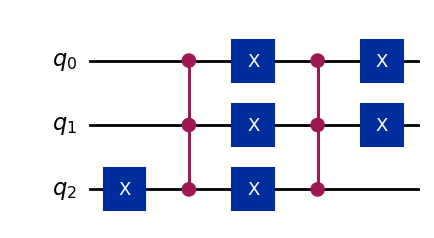

In [116]:
marked_states = ["011", "100"] 

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator

The built-in Qiskit GroverOperator takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle. Here, we decompose the circuit to see the gates within the operator:

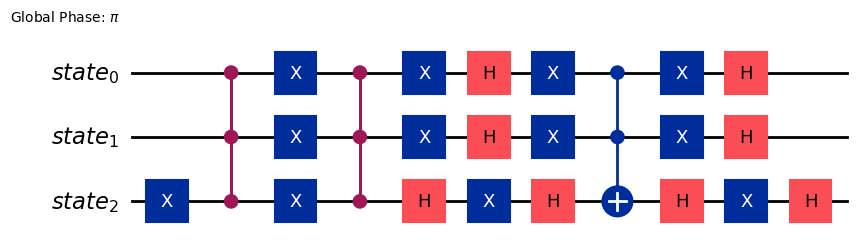

In [117]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this grover_op circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit. There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:

In [118]:
import math
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (grover_op) repeated the optimal number of times. Here we make use of the QuantumCircuit.power(INT) method to repeatedly apply the Grover operator.

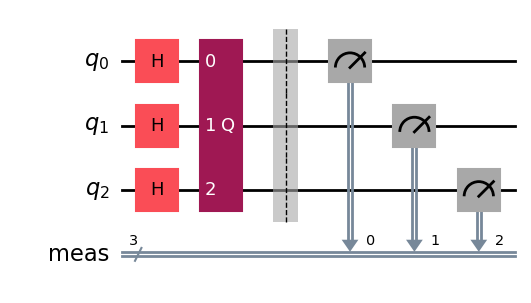

In [ ]:
qc_gen = QuantumCircuit(grover_op.num_qubits)

# Create even superposition of all basis states
qc_gen.h(range(grover_op.num_qubits))

# Apply Grover operator the optimal number of times
qc_gen.compose(grover_op.power(optimal_num_iterations), inplace=True)

# Measure all qubits
qc_gen.measure_all()
qc_gen.draw(output="mpl", style="iqp")

Let's optimize problem for quantum execution

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#fake_backend = FakeTorino()     # try this Heron backend if you like and compare results to the Eagle processors, try also to scale up the number of qubits!
fake_backend = FakeBrisbane() 

target = fake_backend.target    
pm = generate_preset_pass_manager(target=target, optimization_level=3)  #transpilation process using the pass manager, we'll talk later about it

circuit_isa = pm.run(qc_gen)
#circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")  # uncomment this to see the transpiled and optimized circuit using base gates on specific qubits


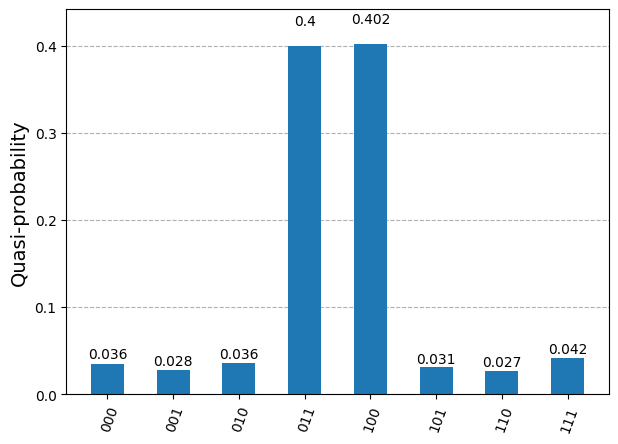

In [ ]:
# To run on local simulator:
from qiskit.visualization import plot_distribution

#aer_sim = AerSimulator()  # use AerSimulator to see what happen scaling up the number of qubit above 5

sampler = Sampler(mode=fake_backend) # if you change backend to AerSimulator, remember to change also in this line the backend used by Sampler!
sampler.options.default_shots = 4000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

plot_distribution(dist) # here we plot quasi-probabilities instead of counts

#### Great result! We successessfully created an algorithm that generalize the creation of the oracle and only depends on the final states that we want to measure!

## Excercise:

1) try to change *marked_states*: adding bits (i.e. expanding the space of the search) or adding more than 2 states to mark.. you'll soon discover the limit caused by noise (simulated by the *FakeProvider* library)

2) to eliminate the effect of noise try using other backends (e.g. *FakeTorino*) or directly the *AerSimulator* instead of a *FakeProvider* to assess the correctness of the oracle definition

## Let's compare different IBM Quantum backends!

Ok not let's go back to the first problem, let's now do a comparison between different IBM Quantum hardware.

To have a look at the results we can expect from the different backend we use the FakeProvider library that import all the characteristics of the backends but use the simulator to run.

In [ ]:
from qiskit_ibm_runtime.fake_provider import *

backends = [FakeWashingtonV2(), FakeTorino(), FakeSherbrooke(), FakeQuebec(), FakeBrisbane(), FakePrague(), FakeOsaka(), FakeKyiv()]
results_backends = []

expected_states = [bits]  # target states of the first Grover algorithm, NOT the generalized one, for simplicity.. feel free to adapt the code yourself!



def get_state_accuracy(counts): # funciton to calculate state accuracy
    expected_counts = 0
    for state in counts.keys():
        if state in expected_states:
            expected_counts = expected_counts + counts[state]
    state_accuracy = expected_counts / shots 
    return str(state_accuracy*100)+"%"


for backend in backends:
    
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_qc = pm.run(qc)
    sampler = Sampler(mode=backend)
    result = sampler.run([isa_qc]).result()

    counts = result[0].data.cr.get_counts()

    state_accuracy = get_state_accuracy(counts)

    results_backends.append((backend.name, counts, state_accuracy))
    print("Results : ", counts)


Results :  {'01': 924, '10': 7, '11': 50, '00': 43}
Results :  {'01': 935, '00': 71, '11': 15, '10': 3}
Results :  {'01': 976, '00': 11, '11': 29, '10': 8}
Results :  {'01': 965, '00': 23, '11': 29, '10': 7}
Results :  {'01': 960, '11': 29, '00': 33, '10': 2}
Results :  {'01': 988, '11': 10, '00': 22, '10': 4}
Results :  {'01': 974, '00': 35, '10': 4, '11': 11}
Results :  {'01': 840, '00': 74, '11': 55, '10': 55}


## Let's plot the histogram
We report the value identified and the occurrences in the set of readings

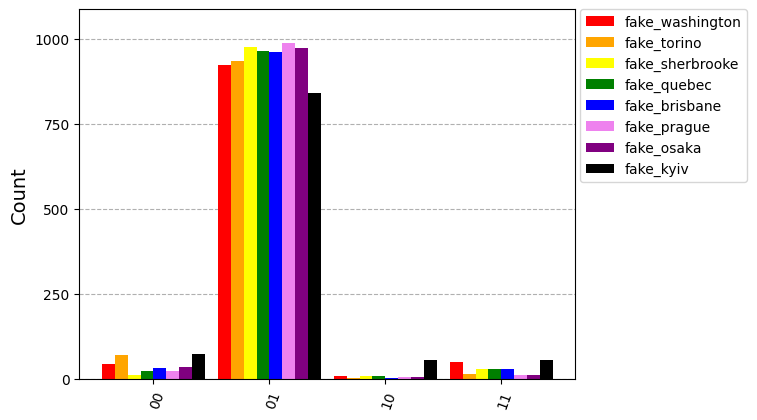

In [37]:
import pandas as pd # handy tools for calculation

plot_histogram([counts for backend_name, counts, state_accuracy in results_backends],
        legend=[backend_name for backend_name, counts, state_accuracy in results_backends],
        sort="asc",
        color=["red", "orange", "yellow", "green", "blue", "violet", "purple", "black"],
        bar_labels=False)


## Here we can see the backend accuracy <a id='sectionB'></a>


In [38]:
results_backends_table = pd.DataFrame(columns=["backend", "state_accuracy"]) # create table
for backend_name, counts, state_accuracy in results_backends:
    results_backends_table.loc[len(results_backends_table)] = [backend_name, state_accuracy] # put values into table
results_backends_table = results_backends_table.sort_values(by=["state_accuracy"], ascending=False).reset_index().iloc[:, 1:] # sort values
results_backends_table 

,backend,state_accuracy
0,fake_prague,96.484375%
1,fake_sherbrooke,95.3125%
2,fake_osaka,95.1171875%
3,fake_quebec,94.23828125%
4,fake_brisbane,93.75%
5,fake_torino,91.30859375%
6,fake_washington,90.234375%
7,fake_kyiv,82.03125%


## We can also choose the most accurate backend and see how results change according to optimization levels <a id='sectionB'></a>


State Accuracy 
optimization_level_0: 79.19921875%
optimization_level_1: 83.3984375%
optimization_level_2: 99.12109375%
optimization_level_3: 98.14453125%


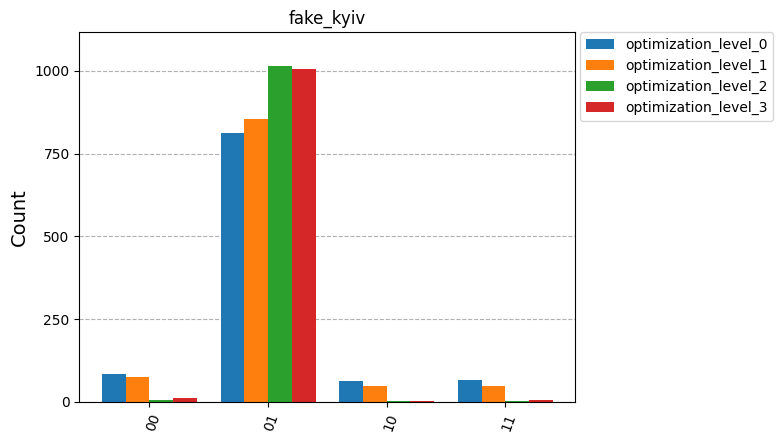

In [ ]:
# compare results from different optimization levels on the worst backend, in my casse FakeKyiv

results_backend1_transpiler = []
worst_backend = FakeKyiv()
optimization_levels = [0,1,2,3]

for optim_level in optimization_levels:

    pm = generate_preset_pass_manager(backend=worst_backend, optimization_level=optim_level)
    isa_qc = pm.run(qc)
    sampler = Sampler(mode=worst_backend)
    result = sampler.run([isa_qc]).result()

    counts = result[0].data.cr.get_counts()

    state_accuracy = get_state_accuracy(counts)

    results_backend1_transpiler.append((optim_level, counts, state_accuracy))
    
# compare state accuracies
print("State Accuracy \n"+
      "\n".join(["optimization_level_"+str(optim_level)+': '+str(state_accuracy) 
                 for optim_level, counts, state_accuracy in results_backend1_transpiler]))

# plot results
plot_histogram([counts for optim_level, counts, state_accuracy in results_backend1_transpiler],
               legend=["optimization_level_"+str(optim_level) for optim_level, counts, state_accuracy in results_backend1_transpiler],
               title=worst_backend.name,
               bar_labels=False)

#### Wow! So this explain the importance of a good transpilation process that optimize the "translation" of the gates declared by us with the basis gates and coupling_map of the the real processor.
Check here for the docs that explain the Qiskit transpilation: https://docs.quantum.ibm.com/guides/transpile

## We run the circuit with the real processor <a id='sectionB'></a>

 

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

token=''
service = QiskitRuntimeService(channel="ibm_quantum", token=token)


In [3]:
print("Available backends:")
service.backends()

Available backends:


[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [28]:
backend = service.least_busy(operational=True, simulator=False)
backend

<IBMBackend('ibm_brisbane')>

In [29]:
shots = 1024           # Number of shots to run the program (experiment)

transpiled = transpile(qc, backend)
sampler = Sampler(mode=backend)

job_exp = sampler.run([transpiled], shots=shots)
result_real = job_exp.result()
counts_real = result_real[0].data.cr.get_counts()

## Let's plot the values <a id='sectionB'></a>
We report the value identified and the occurrences in the set of readings

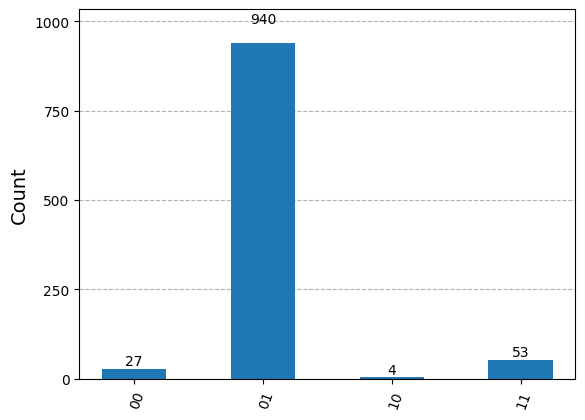

In [30]:
plot_histogram(counts_real)

# The previous value was found in only one machine cycle

How many would it take to find the winner with the classic circuit?



In [30]:
counter=0
for i in ["a","b","c","d"]:
	counter=counter+1
	if i == scelta:
		print("winner found after ", counter) 

winner found after  2
